In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random, math, copy

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_arms = 3

# Oracle theta of each arm
theta = np.array([0.7, 0.5, 0.4])

# Problem 2: Implement classical bandit algorithms 

## 1. The epsilon-greedy Algorithm

In [80]:
def epsilon_greedy(epsilon, N, theta):
    """
    Implement the epsilon-greedy algorithm for a Bernoulli bandit problem.

    Parameters
    ----------
    epsilon : float
        The probability of exploration.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.

    Returns
    -------
    total_reward : float
        Total reward accumulated over N time steps.
    """
    Q = np.zeros(num_arms)  # Estimated values for each arm
    counts = np.zeros(num_arms)  # Count of how many times each arm is pulled
    total_reward = 0  # Total reward tracker

    # Initialization: Pull each arm once
    for arm in range(num_arms):
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] = 1
        Q[arm] = reward
        total_reward += reward

    # Main loop: Epsilon-greedy exploration and exploitation
    for t in range(num_arms, N):
        if np.random.rand() < epsilon:
            # Exploration: choose a random arm
            arm = np.random.randint(num_arms)
        else:
            # Exploitation: choose the arm with the highest estimated value
            arm = np.argmax(Q)
        
        # Simulate pulling the chosen arm
        reward = 1 if np.random.rand() < theta[arm] else 0
        
        counts[arm] += 1
        Q[arm] += (1 / counts[arm]) * (reward - Q[arm])
        
        total_reward += reward
    
    return total_reward

## 2. The UCB (Upper Confidence Bound) Algorithm

In [81]:
def ucb(c, N, theta):
    """
    Implement the UCB (Upper Confidence Bound) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    c : float
        Confidence level parameter for the UCB algorithm.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """

    Q = np.zeros(num_arms)
    counts = np.zeros(num_arms)
    total_reward = 0
    
    # Initialize by pulling each arm once
    for arm in range(num_arms):
        reward = 1 if np.random.rand() < theta[arm] else 0
        Q[arm] = reward
        counts[arm] = 1
        total_reward += reward

    for t in range(num_arms+1, N+1):
        # Avoid division by zero because each arm was pulled once
        ucb_values = Q + c * np.sqrt((2*np.log(t))/counts)
        arm = np.argmax(ucb_values)
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] += 1
        Q[arm] += (1/counts[arm])*(reward - Q[arm])
        total_reward += reward
    return total_reward

## 3. TS (Thompson Sampling) Algorithm

In [82]:
from scipy.stats import beta

def thompson_sampling(N, theta, alpha_init, beta_init):
    """
    Implement the Thompson Sampling (TS) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    alpha_init : array-like
        Initial alpha parameters for the Beta distributions of each arm.
    beta_init : array-like
        Initial beta parameters for the Beta distributions of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """
    alpha = alpha_init.copy()
    beta_ = beta_init.copy()
    total_reward = 0
    for t in range(N):
        sampled_thetas = [np.random.beta(alpha[j], beta_[j]) for j in range(num_arms)]
        arm = np.argmax(sampled_thetas)
        reward = 1 if np.random.rand() < theta[arm] else 0
        total_reward += reward
        alpha[arm] += reward
        beta_[arm] += 1 - reward
    return total_reward


# Problem 3: Each experiment lasts for $N = 5000$ time slots, and we run each experiment $200$ trials. Results are averaged over these $200$ independent trials.

In [83]:
# Parameters
N = 5000
num_trials = 200
epsilons = [0.1, 0.5, 0.9]
cs = [1, 5, 10]

# Two sets of prior parameters for TS
# Set 1: (1,1), (1,1), (1,1)
alpha_set_1 = np.array([1, 1, 1])
beta_set_1 = np.array([1, 1, 1])

# Set 2: (601,401), (401,601), (2,3)
alpha_set_2 = np.array([601, 401, 2])
beta_set_2 = np.array([401, 601, 3])

# True parameters of the arms (as per the oracle, but not known to the algorithm)
theta = np.array([0.7, 0.5, 0.4])

In [84]:
# Epsilon-greedy
print("Epsilon-greedy results:")
for eps in epsilons:
    rewards = []
    for _ in range(num_trials):
        rewards.append(epsilon_greedy(eps, N, theta))
    mean_reward = np.mean(rewards)
    print(f"Epsilon = {eps}, Average total reward over {num_trials} trials: {mean_reward}")

Epsilon-greedy results:
Epsilon = 0.1, Average total reward over 200 trials: 3408.44
Epsilon = 0.5, Average total reward over 200 trials: 3085.66
Epsilon = 0.9, Average total reward over 200 trials: 2748.215


In [85]:
# UCB
print("\nUCB results:")
for c_val in cs:
    rewards = []
    for _ in range(num_trials):
        rewards.append(ucb(c_val, N, theta))
    mean_reward = np.mean(rewards)
    print(f"c = {c_val}, Average total reward over {num_trials} trials: {mean_reward}")


UCB results:
c = 1, Average total reward over 200 trials: 3408.315
c = 5, Average total reward over 200 trials: 2979.74
c = 10, Average total reward over 200 trials: 2829.24


In [86]:
# Thompson Sampling
print("\nThompson Sampling results:")
rewards_set_1 = []
for _ in range(num_trials):
    rewards_set_1.append(thompson_sampling(N, theta, alpha_set_1, beta_set_1))
mean_set_1 = np.mean(rewards_set_1)
print(f"Set 1 Priors (1,1),(1,1),(1,1), Average total reward: {mean_set_1}")

rewards_set_2 = []
for _ in range(num_trials):
    rewards_set_2.append(thompson_sampling(N, theta, alpha_set_2, beta_set_2))
mean_set_2 = np.mean(rewards_set_2)
print(f"Set 2 Priors (601,401),(401,601),(2,3), Average total reward: {mean_set_2}")



Thompson Sampling results:
Set 1 Priors (1,1),(1,1),(1,1), Average total reward: 3480.75
Set 2 Priors (601,401),(401,601),(2,3), Average total reward: 3492.41


# Problem 4

## 4.1 Find the optimal results for each algorithm

Best epsilon: 0.03
Maximum average total reward: 3457.02


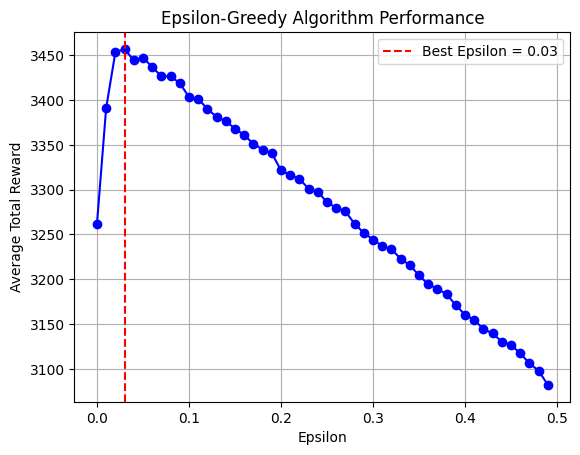

In [94]:
num_trials = 100

epsilon_values = np.arange(0, 0.5, 0.01)
average_rewards = []

for eps in epsilon_values:
    rewards = []
    for _ in range(num_trials):
        rewards.append(epsilon_greedy(eps, N, theta))
    average_rewards.append(np.mean(rewards))

# Find the best epsilon
best_epsilon = epsilon_values[np.argmax(average_rewards)]
print(f"Best epsilon: {best_epsilon:.2f}")
print(f"Maximum average total reward: {np.max(average_rewards):.2f}")

# Plot the results
import matplotlib.pyplot as plt

plt.plot(epsilon_values, average_rewards, marker='o', linestyle='-', color = 'b')
plt.axvline(x=best_epsilon, color='r', linestyle='--', label=f'Best Epsilon = {best_epsilon:.2f}')
plt.xlabel('Epsilon')
plt.ylabel('Average Total Reward')
plt.title('Epsilon-Greedy Algorithm Performance')
plt.legend()
plt.grid(True)
plt.show()


Best c value: 0.40
Maximum average total reward: 3483.90


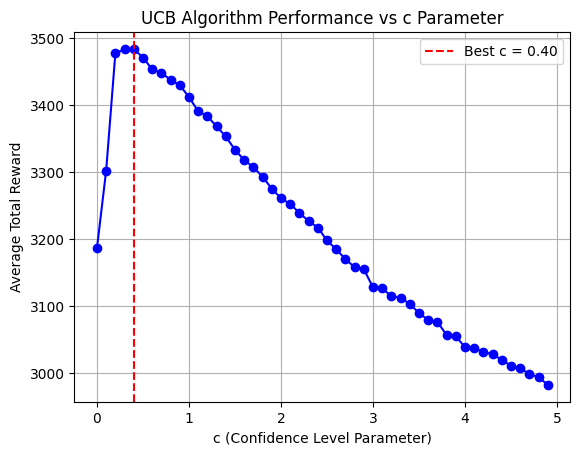

In [93]:
c_values = np.arange(0, 5, 0.1)
average_rewards = []

# Run UCB for each value of c and compute the average reward over multiple trials
for c in c_values:
    rewards = []
    for _ in range(num_trials):
        total_reward = ucb(c, N, theta)
        rewards.append(total_reward)
    average_rewards.append(np.mean(rewards))

# Identify the best c
best_c_index = np.argmax(average_rewards)
best_c = c_values[best_c_index]
best_average_reward = average_rewards[best_c_index]

print(f"Best c value: {best_c:.2f}")
print(f"Maximum average total reward: {best_average_reward:.2f}")

# Plot the results
plt.plot(c_values, average_rewards, marker='o', linestyle='-', color='b')
plt.axvline(x=best_c, color='r', linestyle='--', label=f'Best c = {best_c:.2f}')
plt.xlabel('c (Confidence Level Parameter)')
plt.ylabel('Average Total Reward')
plt.title('UCB Algorithm Performance vs c Parameter')
plt.legend()
plt.grid(True)
plt.show()

# Problem 6

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import pandas as pd

num_arms = 3

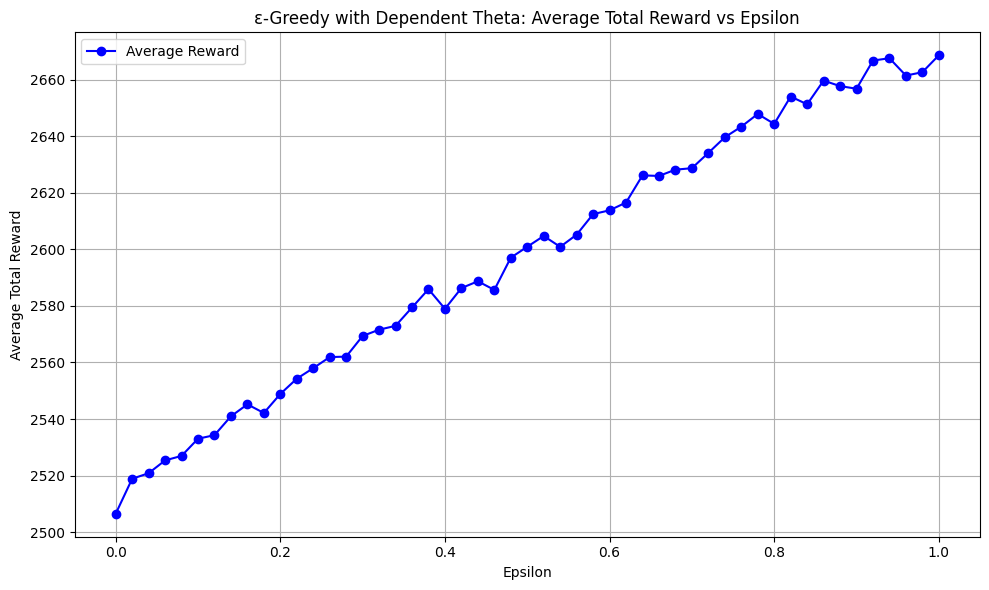

Best epsilon: 1.00
Maximum average total reward: 2668.57


In [2]:
# Initialize global variables for counts and estimated thetas
count = [0, 0, 0]  # Corresponds to Arm 1, Arm 2, Arm 3
theta = [0.0, 0.0, 0.0]  # Estimated thetas for Arm 1, Arm 2, Arm 3

def init_greedy():
    """
    Initializes the counts and estimated thetas for the greedy algorithm.
    """
    global count, theta
    count = [0, 0, 0]  # Reset counts for Arms 1, 2, 3
    theta = [0.0, 0.0, 0.0]  # Reset estimated thetas

def greedy_dependence(n, epsilon, initial_theta_oracled, p):
    """
    Greedy algorithm with dependency in theta_oracled.

    Parameters:
    - n: Number of time steps
    - epsilon: Exploration rate
    - initial_theta_oracled: Initial probabilities for each arm [θ1, θ2, θ3]
    - p: Probability adjustment parameter
    """
    global count, theta
    init_greedy()  # Initialize counts and estimates
    total_reward = 0  # Total actual rewards obtained

    # Deep copy to avoid modifying the original initial_theta_oracled
    current_theta = initial_theta_oracled.copy()

    for t in range(n):
        prob = random.random()  # Generate a random number in [0,1)

        if prob < epsilon:
            # Explore: choose a random arm from {0,1,2} corresponding to Arm 1, 2, 3
            arm = random.randint(0, 2)
        else:
            # Exploit: choose the arm with the highest estimated theta
            arm = np.argmax(theta)
            if theta[arm] == 0:
                # If all estimated thetas are 0, choose a random arm
                arm = random.randint(0, 2)

        # Simulate pulling the chosen arm: reward is 1 with probability current_theta[arm]
        r_i = np.random.binomial(1, current_theta[arm])

        # Accumulate the actual reward
        total_reward += r_i

        # Update counts and estimated thetas using incremental averaging
        count[arm] += 1
        theta[arm] += (r_i - theta[arm]) / count[arm]

        # Update theta_oracled based on the outcome
        if r_i == 1:
            # If reward obtained, decrease theta of pulled arm and increase others
            current_theta[arm] = max(current_theta[arm] - p, 0.0)
            for other_arm in range(3):
                if other_arm != arm:
                    current_theta[other_arm] = min(current_theta[other_arm] + p / 2, 1.0)
        else:
            # If no reward, increase theta of pulled arm and decrease others
            current_theta[arm] = min(current_theta[arm] + p, 1.0)
            for other_arm in range(3):
                if other_arm != arm:
                    current_theta[other_arm] = max(current_theta[other_arm] - p / 2, 0.0)

    return total_reward

# Define the initial true reward probabilities (unknown to the algorithm)
initial_theta_oracled = [0.7, 0.5, 0.4]  # θ1=0.7, θ2=0.5, θ3=0.4

# Experiment Parameters
epsilon_values = np.arange(0, 1.02, 0.02)  # Epsilon from 0 to 1 in steps of 0.02
repeat_time = 100  # Number of trials for each epsilon
N = 5000  # Number of time steps per trial
p = 0.005  # Probability adjustment parameter

rewards = np.zeros(len(epsilon_values))  # Average rewards for each epsilon

# Run experiments for each epsilon
for i, eps in enumerate(epsilon_values):
    for trial in range(repeat_time):
        # For each trial, reset the initial theta_oracled
        theta_oracled = initial_theta_oracled.copy()
        reward = greedy_dependence(N, eps, theta_oracled, p)
        rewards[i] += reward / repeat_time

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Average Total Reward vs. Epsilon
plt.plot(epsilon_values, rewards, marker='o', linestyle='-', color='blue', label='Average Reward')
plt.scatter(epsilon_values, rewards, color='red', s=10)
plt.xlabel('Epsilon')
plt.ylabel('Average Total Reward')
plt.title('ε-Greedy with Dependent Theta: Average Total Reward vs Epsilon')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Identify and print the best epsilon based on rewards
best_index = np.argmax(rewards)
best_epsilon = epsilon_values[best_index]
best_reward = rewards[best_index]
print(f"Best epsilon: {best_epsilon:.2f}")
print(f"Maximum average total reward: {best_reward:.2f}")


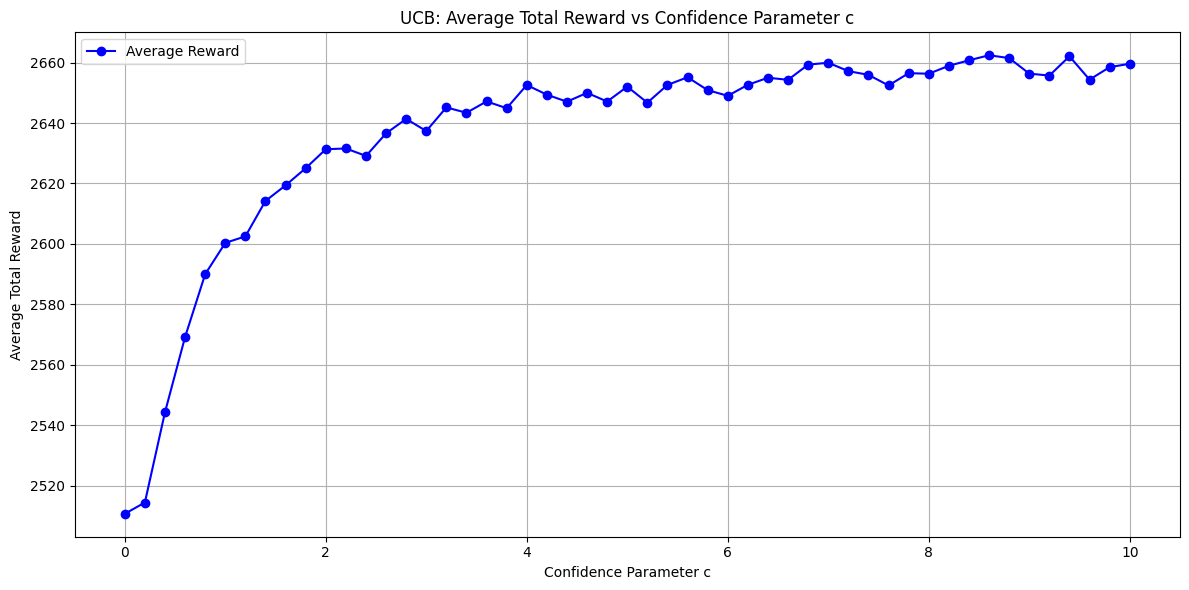

Best c: 8.60
Maximum average total reward: 2662.44


In [3]:
def ucb_dependence(c, N, initial_theta_oracled, p=0.005):
    """
    UCB algorithm with independent arms.

    Parameters:
    - c: Confidence parameter for UCB
    - N: Number of time steps
    - initial_theta_oracled: List of initial true reward probabilities for each arm [θ1, θ2, θ3]
    - p: Probability adjustment parameter
    """
    num_arms = 3
    Q = np.zeros(num_arms)          # Estimated rewards for each arm
    counts = np.zeros(num_arms)     # Number of times each arm has been pulled
    total_reward = 0                 # Total accumulated reward

    # Deep copy to avoid modifying the original initial_theta_oracled
    theta_oracled = initial_theta_oracled.copy()

    # Initialize by pulling each arm once
    for arm in range(num_arms):
        reward = 1 if random.random() < theta_oracled[arm] else 0
        Q[arm] = reward
        counts[arm] = 1
        total_reward += reward

        # Update theta_oracled based on the outcome
        if reward == 1:
            # If reward obtained, decrease the probability of the pulled arm and increase others
            theta_oracled[arm] = max(theta_oracled[arm] - p, 0.0)
            for other_arm in range(num_arms):
                if other_arm != arm:
                    theta_oracled[other_arm] = min(theta_oracled[other_arm] + p / 2, 1.0)
        else:
            # If no reward, increase the probability of the pulled arm and decrease others
            theta_oracled[arm] = min(theta_oracled[arm] + p, 1.0)
            for other_arm in range(num_arms):
                if other_arm != arm:
                    theta_oracled[other_arm] = max(theta_oracled[other_arm] - p / 2, 0.0)

    # Run UCB algorithm for remaining time steps
    for t in range(num_arms, N):
        # Compute UCB values for each arm
        ucb_values = Q + c * np.sqrt((2 * np.log(t + 1)) / counts)
        arm = np.argmax(ucb_values)

        # Pull the selected arm and observe the reward
        reward = 1 if random.random() < theta_oracled[arm] else 0
        total_reward += reward

        # Update counts and estimated rewards
        counts[arm] += 1
        Q[arm] += (reward - Q[arm]) / counts[arm]

        # Update theta_oracled based on the outcome
        if reward == 1:
            # If reward obtained, decrease the probability of the pulled arm and increase others
            theta_oracled[arm] = max(theta_oracled[arm] - p, 0.0)
            for other_arm in range(num_arms):
                if other_arm != arm:
                    theta_oracled[other_arm] = min(theta_oracled[other_arm] + p / 2, 1.0)
        else:
            # If no reward, increase the probability of the pulled arm and decrease others
            theta_oracled[arm] = min(theta_oracled[arm] + p, 1.0)
            for other_arm in range(num_arms):
                if other_arm != arm:
                    theta_oracled[other_arm] = max(theta_oracled[other_arm] - p / 2, 0.0)

    return total_reward

# Define the initial true reward probabilities (unknown to the algorithm)
initial_theta_oracled = [0.7, 0.5, 0.4]  # [θ1, θ2, θ3]

# Experiment Parameters
c_values = np.arange(0.0, 10.2, 0.2)  # Confidence parameter c from 0 to 10 in steps of 0.2
repeat_time = 100  # Number of trials for each c
N = 5000  # Number of time steps per trial
p = 0.005  # Probability adjustment parameter

average_rewards = np.zeros(len(c_values))  # Average rewards for each c

# Run experiments for each c
for i, c in enumerate(c_values):
    for trial in range(repeat_time):
        # For each trial, reset the initial_theta_oracled
        theta_oracled = initial_theta_oracled.copy()
        reward = ucb_dependence(c, N, theta_oracled, p)
        average_rewards[i] += reward / repeat_time

# Plot the results
plt.figure(figsize=(12, 6))

# Plot Average Total Reward vs. Confidence Parameter c
plt.plot(c_values, average_rewards, marker='o', linestyle='-', color='blue', label='Average Reward')
plt.scatter(c_values, average_rewards, color='red', s=10)
plt.xlabel('Confidence Parameter c')
plt.ylabel('Average Total Reward')
plt.title('UCB: Average Total Reward vs Confidence Parameter c')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Identify and print the best c based on rewards
best_index = np.argmax(average_rewards)
best_c = c_values[best_index]
best_reward = average_rewards[best_index]
print(f"Best c: {best_c:.2f}")
print(f"Maximum average total reward: {best_reward:.2f}")

In [3]:
def thompson_sampling_dependence(N, theta_oracled, alpha_init, beta_init, p=0.005):
    num_arms = 3
    alpha = alpha_init.copy()
    beta = beta_init.copy()
    total_reward = 0.0
    
    # Deep copy to avoid modifying the original theta_oracled
    theta_current = theta_oracled.copy()
    
    for t in range(N):
        # Sample theta from Beta distributions for each arm
        sampled_thetas = [np.random.beta(alpha[j], beta[j]) for j in range(num_arms)]
        
        # Select the arm with the highest sampled theta
        arm = np.argmax(sampled_thetas)
        
        # Simulate pulling the selected arm: reward is 1 with probability theta_current[arm]
        reward = 1 if np.random.random() < theta_current[arm] else 0
        total_reward += reward
        
        # Update the Beta distribution parameters for the selected arm
        alpha[arm] += reward
        beta[arm] += (1 - reward)
        
        # Update theta_oracled based on the outcome
        if reward == 1:
            # If reward obtained, decrease theta of pulled arm and increase others
            theta_current[arm] = max(theta_current[arm] - p, 0.0)
            for other_arm in range(num_arms):
                if other_arm != arm:
                    theta_current[other_arm] = min(theta_current[other_arm] + p / 2, 1.0)
        else:
            # If no reward, increase theta of pulled arm and decrease others
            theta_current[arm] = min(theta_current[arm] + p, 1.0)
            for other_arm in range(num_arms):
                if other_arm != arm:
                    theta_current[other_arm] = max(theta_current[other_arm] - p / 2, 0.0)
                    
    return total_reward

In [4]:
def dependency_aware_thompson_sampling(N, theta, alpha_init, beta_init, p=0.005, epsilon=1e-2, gamma=1e-4):
    alpha = alpha_init.copy()
    beta  = beta_init.copy()
    K = len(alpha)
    theta_current = theta.copy()
    total_reward = 0
    
    for t in range(N):
        # Epsilon-greedy: with prob epsilon, pick a random arm
        if np.random.rand() < epsilon:
            chosen_arm = np.random.choice(K)
        else:
            # Otherwise, Thompson sample from each arm's Beta posterior
            samples = [np.random.beta(alpha[i], beta[i]) for i in range(K)]
            chosen_arm = np.argmax(samples)
        
        # Observe reward from environment
        reward = (np.random.rand() < theta_current[chosen_arm])
        total_reward += reward
        
        # --- Update Beta posterior for chosen arm and other arms ---
        if reward:
            # Chosen arm gets a standard Beta update
            alpha[chosen_arm] += 1
            
            # If gamma > 0, nudge alpha of the other arms
            for other_arm in range(K):
                if other_arm != chosen_arm:
                    alpha[other_arm] += gamma
        else:
            # Chosen arm gets a standard Beta update
            beta[chosen_arm] += 1
            
            # If gamma > 0, nudge beta of the other arms
            for other_arm in range(K):
                if other_arm != chosen_arm:
                    beta[other_arm] += gamma
        
        # environment update
        if reward:
            theta_current[chosen_arm] = max(theta_current[chosen_arm] - p, 0.0)
            for other_arm in range(K):
                if other_arm != chosen_arm:
                    theta_current[other_arm] = min(theta_current[other_arm] + p/2, 1.0)
        else:
            theta_current[chosen_arm] = min(theta_current[chosen_arm] + p, 1.0)
            for other_arm in range(K):
                if other_arm != chosen_arm:
                    theta_current[other_arm] = max(theta_current[other_arm] - p/2, 0.0)
    
    return total_reward


===== Best Average Rewards =====
Thompson Sampling Independent: 2667.74
Dependency-Aware Thompson Sampling Independent: 2673.80

===== Top 5 Parameter Combinations for Thompson Sampling Independent =====
 Alpha1  Alpha2  Alpha3  Beta1  Beta2  Beta3  Avg Reward TS
    600     300     450      1      1     31        2667.74
    450     450     300      1     16     16        2664.94
    450     450     450      1      1     31        2663.02
    450     450     450      1     16     31        2663.00
    450     300     450      1      1     31        2662.90

===== Top 5 Parameter Combinations for Dependency-Aware Thompson Sampling Independent =====
 Alpha1  Alpha2  Alpha3  Beta1  Beta2  Beta3  Best Epsilon DA-TS  Best Gamma DA-TS  Avg Reward DA-TS
    600     450     450     16     16     31               0.001          0.000001           2673.80
    450     450     450      1      1     31               0.007          0.000001           2671.78
    600     450     450      1      1   

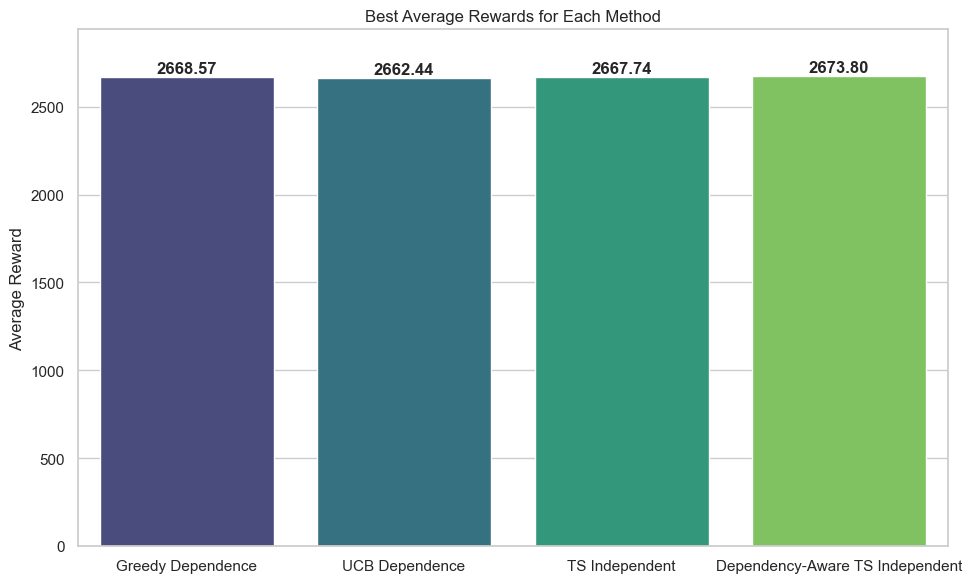

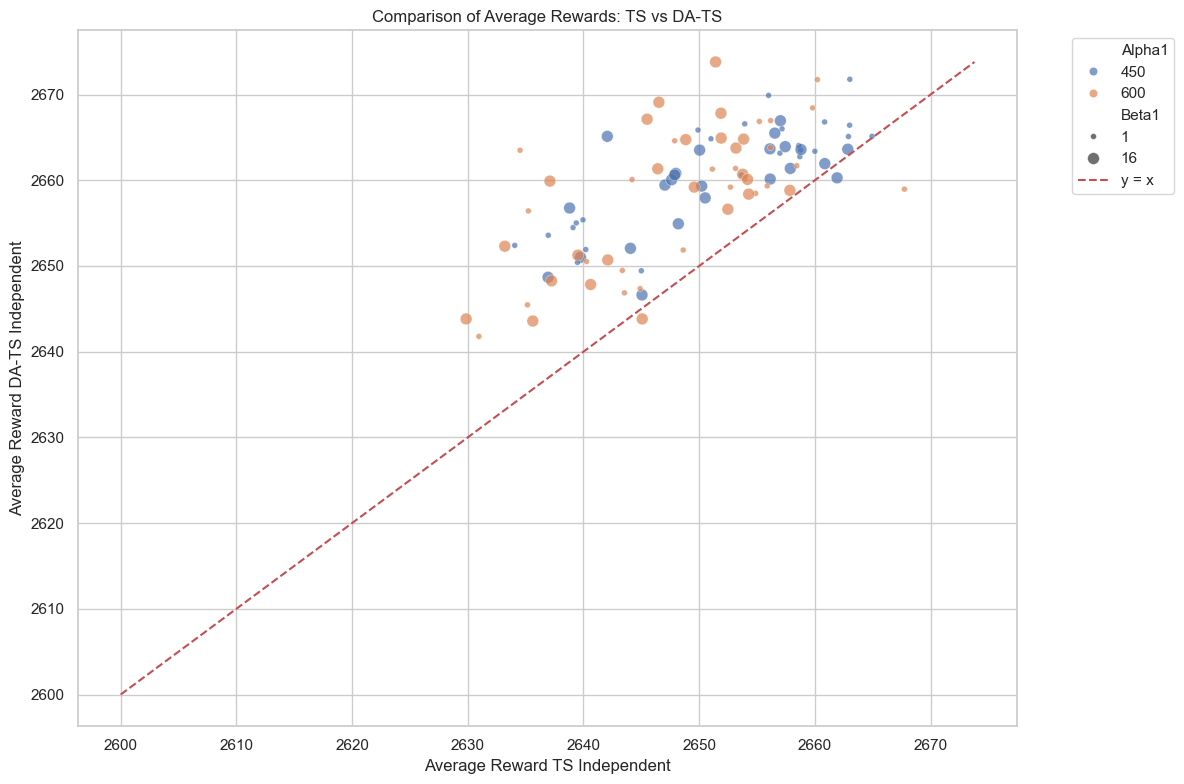

<Figure size 640x480 with 0 Axes>

In [6]:
# Define the true reward probabilities (independent arms)
theta1_true = 0.5
theta2_true = 0.4
theta3_true = 0.7
theta = [theta3_true, theta1_true, theta2_true]  # [θ1, θ2, θ3] = [0.7, 0.5, 0.4]

# ---------- Parameter Ranges for Three Arms ----------
alpha1_values = [450, 600]
beta1_values  = [1, 16]
alpha2_values = [300, 450]
beta2_values  = [1, 16]
alpha3_values = [150, 300, 450]
beta3_values  = [16, 31]

N = 5000
repeat_time = 50

# ---------- Generate All Parameter Combinations for Three Arms ----------
parameter_combinations = list(product(
    alpha1_values, alpha2_values, alpha3_values,
    beta1_values, beta2_values, beta3_values
))

# ---------- Initialize Result Lists for Both Algorithms ----------
results_ts_independent = []  # For thompson_sampling_independent
results_da_ts_independent = []  # For dependency_aware_thompson_sampling (now independent)

# ---------- Running Both Algorithms Across All Parameter Combinations ----------
for idx, (alpha1_val, alpha2_val, alpha3_val, beta1_val, beta2_val, beta3_val) in enumerate(parameter_combinations):
    alpha_init_ts = [alpha1_val, alpha2_val, alpha3_val]
    beta_init_ts = [beta1_val, beta2_val, beta3_val]

    alpha_init_da = [alpha1_val, alpha2_val, alpha3_val]
    beta_init_da = [beta1_val, beta2_val, beta3_val]

    # ---------- Run Trials for Thompson Sampling Independent ----------
    total_reward_ts = 0.0
    for _ in range(repeat_time):
        theta_oracled = [0.7, 0.5, 0.4]  # [θ1, θ2, θ3]
        reward = thompson_sampling_dependence(N, theta_oracled, alpha_init_ts, beta_init_ts, p=0.005)
        total_reward_ts += reward / repeat_time

    # ---------- Run Trials for Dependency-Aware Thompson Sampling ----------
    epsilon_values = [1e-2,7e-3, 5e-3, 3e-3, 1e-3]
    gamma_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    
    best_reward_da = -np.inf
    best_epsilon = None
    best_gamma = None

    for epsilon in epsilon_values:
        for gamma in gamma_values:
            total_reward_da = 0.0
            for _ in range(repeat_time):
                # Reset theta_oracled for each trial
                theta_oracled = [theta3_true, theta1_true, theta2_true]  # [θ1, θ2, θ3]
                # Run DA-TS with current epsilon and gamma
                reward = dependency_aware_thompson_sampling(
                    N, theta_oracled, alpha_init_da, beta_init_da, 
                    p=0.005, epsilon=epsilon, gamma=gamma
                )
                total_reward_da += reward / repeat_time
            
            # Check if this (epsilon, gamma) pair yields a better reward
            if total_reward_da > best_reward_da:
                best_reward_da = total_reward_da
                best_epsilon = epsilon
                best_gamma = gamma
    
    # ---------- Store Results ----------
    results_ts_independent.append({
        'Alpha1': alpha1_val,
        'Alpha2': alpha2_val,
        'Alpha3': alpha3_val,
        'Beta1': beta1_val,
        'Beta2': beta2_val,
        'Beta3': beta3_val,
        'Avg Reward TS': total_reward_ts
    })
    results_da_ts_independent.append({
        'Alpha1': alpha1_val,
        'Alpha2': alpha2_val,
        'Alpha3': alpha3_val,
        'Beta1': beta1_val,
        'Beta2': beta2_val,
        'Beta3': beta3_val,
        'Best Epsilon DA-TS': best_epsilon,
        'Best Gamma DA-TS': best_gamma,
        'Avg Reward DA-TS': best_reward_da
    })

# ---------- Convert Results to DataFrames ----------
df_ts = pd.DataFrame(results_ts_independent)
df_da = pd.DataFrame(results_da_ts_independent)

# ---------- Merge DataFrames for Easier Comparison ----------
df_combined = pd.merge(df_ts, df_da, on=['Alpha1', 'Alpha2', 'Alpha3', 'Beta1', 'Beta2', 'Beta3'])

# ---------- Find Best Outcomes for Each Method ----------

best_avg_ts = df_ts['Avg Reward TS'].max()
best_avg_da = df_da['Avg Reward DA-TS'].max()

# ---------- Enhanced Printing ----------

print("===== Best Average Rewards =====")
print(f"Thompson Sampling Independent: {best_avg_ts:.2f}")
print(f"Dependency-Aware Thompson Sampling Independent: {best_avg_da:.2f}")

# ---------- List Top 5 Parameter Combinations for Each Method ----------

print("\n===== Top 5 Parameter Combinations for Thompson Sampling Independent =====")
top5_ts = df_ts.sort_values(by='Avg Reward TS', ascending=False).head(5)
print(top5_ts.to_string(index=False))

print("\n===== Top 5 Parameter Combinations for Dependency-Aware Thompson Sampling Independent =====")
top5_da = df_da.sort_values(by='Avg Reward DA-TS', ascending=False).head(5)
print(top5_da.to_string(index=False))

# ---------- Plotting ----------

# Set the style for seaborn
sns.set(style="whitegrid")

# 1. Bar Plot of Best Average Rewards
greedy_dependence_avg = 2668.57
ucb_dependence_avg = 2662.44
plt.figure(figsize=(10, 6))
methods = ['Greedy Dependence', 'UCB Dependence', 'TS Independent', 'Dependency-Aware TS Independent']
avg_rewards = [greedy_dependence_avg, ucb_dependence_avg, best_avg_ts, best_avg_da]
# Fix deprecated palette usage in barplot
sns.barplot(x=methods, 
            y=avg_rewards, 
            hue=methods,  # Assign x to hue 
            legend=False, # Hide redundant legend
            palette="viridis")
plt.ylabel('Average Reward')
plt.title('Best Average Rewards for Each Method')
plt.ylim(0, max(avg_rewards)*1.1)
for i, v in enumerate(avg_rewards):
    plt.text(i, v + max(avg_rewards)*0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Scatter Plot Comparing Both Methods with Reference Line
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_combined,
    x='Avg Reward TS',
    y='Avg Reward DA-TS',
    hue='Alpha1',
    size='Beta1',
    palette='deep',
    alpha=0.7
)
# Add reference line y = x
max_val = max(df_combined['Avg Reward TS'].max(), df_combined['Avg Reward DA-TS'].max())
plt.plot([2600, max_val], [2600, max_val], 'r--', label='y = x')
plt.xlabel('Average Reward TS Independent')
plt.ylabel('Average Reward DA-TS Independent')
plt.title('Comparison of Average Rewards: TS vs DA-TS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Optional: Save Plots
plt.savefig('pics/best_average_rewards.png')
plt.savefig('pics/comparison_scatter.png')